In [5]:
import numpy as np
from reconstruction import epipolar
from scipy import interpolate, linalg
from tools import util
import cv2
def sync_iter(fps1, fps2, detect1, detect2, frame1, frame2, maxIter=200, threshold=10, step=10, p_min=0, p_max=6, verbose=False):
    '''
    This function is a modified implementation of the Iterative Algorithm from the following paper 

    >>> Albl, Cenek, et al. "On the two-view geometry of unsynchronized cameras." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.
    
    The function returns both the estimated time shift (beta) and the according ratio of inliers, which can be considered as scoring
    '''


    def solver(s1,s2,ds,d):
        '''
        This function reads data of 9 points and return a list of possible solution for Beta and F
        '''

        # Create design matrices A1, A2
        A1 = np.array([s1[0]*s2[0],s1[0]*s2[1],s1[0], s1[1]*s2[0],s1[1]*s2[1],s1[1], s2[0],s2[1],np.ones(9)]).T
        A2 = np.array([s1[0]*ds[0],s1[0]*ds[1],np.zeros(9), s1[1]*ds[0],s1[1]*ds[1],np.zeros(9), ds[0],ds[1],np.zeros(9)]).T
        # Compute eigenvalue
        w = -linalg.eigvals(A1,A2)
        w[np.iscomplex(w)] = np.inf
        betas = w.real[np.isfinite(w)]

        # compute fundamental matrix F using shifted data
        M = np.empty((0,10))
        for beta in betas:
            x2 = s2 + beta*ds
            # F = ep.compute_fundamental(s1,x2)
            F, mask = cv2.findFundamentalMat(s1[:2].T,x2[:2].T,method=cv2.FM_8POINT)

            if len(np.ravel(F)) == 9:
                M_i = np.append(np.ravel(F),np.array([beta*d]))
                M = np.vstack((M, M_i))

        return M


    def error(M):
        try:
            detect2_temp = np.vstack((detect2[0]-M[-1],detect2[1:]))
            pts1, pts2 = util.match_overlap(detect1, detect2_temp)
            return epipolar.Sampson_error(util.homogeneous(pts1[1:]), util.homogeneous(pts2[1:]), M[:9].reshape((3,3)))
        except:
            return None


    def ransac(d, maxIter, threshold):
        InliersMax = 0
        numSample = min(detect1.shape[1], detect2.shape[1])
        result = np.zeros((10))
        for i in range(maxIter):
            sampleIdx = np.random.choice(np.arange(numSample-2*abs(d)), size=9, replace=False)
            timestamp = detect2[0,sampleIdx]
            s1 = np.asarray(interpolate.splev(timestamp, spline1))
            s2 = np.asarray(interpolate.splev(timestamp, spline2))
            ds = np.asarray(interpolate.splev(timestamp+d, spline2)) - s2
            M = solver(s1,s2,ds,d)
            if len(M) != 0:
                if len(M.shape)==1:
                    M = np.expand_dims(M,axis=0)
                for Mi in M:
                    err = error(Mi)
                    if err is not None:
                        numInliers = np.sum(err<threshold) / len(err)
                        if numInliers > InliersMax:
                            result = Mi
                            InliersMax = numInliers
        return -result[-1], InliersMax


    # Pre-processing
    alpha = fps1 / fps2
    beta_prior = frame1/alpha - frame2
    detect1_ori, detect2_ori = detect1, detect2
    detect1 = np.vstack((detect1[0]/alpha,detect1[1:]))
    detect2 = np.vstack((detect2[0]+beta_prior,detect2[1:]))

    spline1, _ = interpolate.splprep(detect1[1:], u=detect1[0], s=0, k=3)
    spline2, _ = interpolate.splprep(detect2[1:], u=detect2[0], s=0, k=3)

    # The Iterative Algorithm
    skip, maxInlier, k = 0, 0, 0
    d, p, beta = 2**p_min, p_min, beta_prior

    while k < step:

        # Ransac with d
        beta1, Inlier1 = ransac(d=d, maxIter=maxIter, threshold=threshold)

        # Ransac with -d
        beta2, Inlier2 = ransac(d=-d, maxIter=maxIter, threshold=threshold)

        # Select the better one
        beta_temp = beta1 if Inlier1 >= Inlier2 else beta2
        Inlier = Inlier1 if Inlier1 >= Inlier2 else Inlier2

        if verbose:
            print('d:{}, beta:{:.3f}, maxInlier:{}, Inlier:{}'.format(d, (beta+beta_temp)*alpha, maxInlier, Inlier))

        if skip > p_max:
                break
        elif Inlier < maxInlier:
            if p < p_max:
                p += 1
            else:
                p = 0
            d = 2**p
            skip += 1
        else:
            beta += beta_temp
            maxInlier = Inlier
            detect2 = np.vstack((detect2_ori[0]+beta,detect2_ori[1:]))
            spline2, _ = interpolate.splprep(detect2[1:], u=detect2[0], s=0, k=3)
            skip = 0
            k += 1

    return beta*alpha, maxInlier

In [11]:
fps1 = 50
fps2 = 50
joint = 10
detect1 = np.loadtxt('../../bodypose3d/WalkDog_55011271.dat', usecols=[0, joint*2+1, joint*2+2]).T
detect2 = np.loadtxt('../../bodypose3d/WalkDog_58860488.dat', usecols=[0, joint*2+1, joint*2+2]).T[:, 100:]
frame1 = 1
frame2 = 1

# p_min = 0
# p_max =  6
# beta_prior = 1
# alpha = 1
# beta_prior = frame1/alpha - frame2
# print(beta_prior)
# d, p, beta = 2**p_min, p_min, beta_prior

In [231]:
sync_iter(fps1, fps2, detect1, detect2, frame1, frame2, maxIter=200, threshold=8, step=10, p_min=0, p_max=20, verbose=False)

(2136.25087431681, 1.0)

In [7]:
def sync_bf(fps1, fps2, detect1, detect2, frame1, frame2, r=5):
    '''
    Brute-force method for temporal synchronization of two series of detections

    r is the half length of the search interval in unit second

    Function returns both the time shift (beta) and the temporal overlap of the two series of detections in unit second
    '''


    def search(beta_list, thres=1):
        # print(beta_list)
        maxInlier = 0
        beta_est = 0
        for beta in beta_list:
            # detection adjust with $beta frames
            detect2_temp = np.vstack((detect2[0]+beta,detect2[1:]))
            pts1, pts2 = util.match_overlap(detect1_temp, detect2_temp)

            F, mask = cv2.findFundamentalMat(pts1[1:].T, pts2[1:].T, method=cv2.FM_RANSAC, ransacReprojThreshold=thres)
            inlier = sum(mask.reshape(-1,)) #/ len(pts1[0])

            if inlier > maxInlier:
                maxInlier = inlier
                beta_est = beta

        return beta_est, maxInlier


    # Pre-processing
    alpha = fps1 / fps2
    detect1_temp = np.vstack((detect1[0]/alpha,detect1[1:]))
    beta_prior = frame1/alpha - frame2
    # print(detect1_temp.shape)
    # Two-stage search
    beta_coarse = np.arange(beta_prior-r*fps2, beta_prior+r*fps2, fps2)
    beta_est, _ = search(beta_coarse)
    print(beta_est, _)
    beta_fine = np.arange(beta_est-fps2/2, beta_est+fps2, fps2/4)
    beta_est, numInlier  = search(beta_fine)
    print(beta_est, numInlier)
    beta_fine = np.arange(beta_est-fps2/2, beta_est+fps2/2, fps2/50)
    beta_est, numInlier  = search(beta_fine)
    
    print(beta_est, numInlier)

    # Result
    beta = beta_est * alpha
    overlap_second = numInlier/fps1

    return beta, overlap_second

In [18]:
time_diff = 1.33432
detect2 = np.loadtxt('../../bodypose3d/WalkDog_58860488.dat', usecols=[0, joint*2+1, joint*2+2]).T[:, int(time_diff*fps2):]
sync_bf(fps1, fps2, detect1, detect2, frame1, frame2, r=30)

0.0 857
0.0 857
0.0 857


(0.0, 17.14)

In [15]:
detect2_tmp

array([[ 166.,  167.,  168., ..., 2235., 2236., 2237.],
       [ 538.,  538.,  538., ...,  619.,  619.,  619.],
       [ 576.,  576.,  576., ...,  524.,  524.,  524.]])

In [28]:
import matplotlib.pyplot as plt
inlier_list = []
threshold = 10

time_diff = 1.33432
detect2 = np.loadtxt('../../bodypose3d/WalkDog_58860488.dat', usecols=[0, joint*2+1, joint*2+2]).T[:, int(time_diff*fps2):]
sync_bf(fps1, fps2, detect1, detect2, frame1, frame2, r=30)

print(1.33432*fps2)
time_span = 10 * fps1
for i in range(-time_span, time_span):
    detect2_tmp = np.vstack((detect2[0]+i,detect2[1:]))
    pts1, pts2 = util.match_overlap(detect1, detect2_tmp)
    F, mask = cv2.findFundamentalMat(pts1[1:].T, pts2[1:].T, method=cv2.FM_RANSAC, ransacReprojThreshold=threshold)
    inlier = sum(mask.reshape(-1,))
    inlier_ratio = inlier / pts1.shape[1]
    inlier_list.append([i, inlier, inlier_ratio])
    # print(i, inlier)
inlier_list = np.array(inlier_list).T

0.0 857
0.0 857
0.0 857
66.716


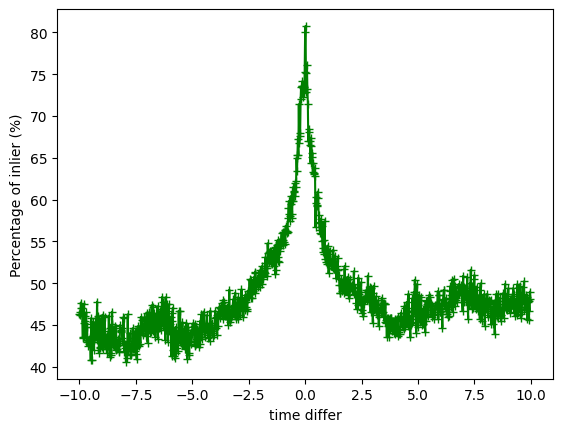

In [42]:
plt.xlabel('time differ')
plt.ylabel('Percentage of inlier (%)')
plt.plot(inlier_list[0]/fps1, inlier_list[2]*100,'g-+')